In [1]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

# load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# original library
sys.path.append('../../')
import common as com
import pytorch_modeler as modeler

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# ML lib
import scipy
from scipy.stats import zscore
#from umap import UMAP
from sklearn.mixture import GaussianMixture
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis


import librosa
import IPython
import librosa.display

# load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/eval{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '01_eval.py')

# Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_frame257/dcase2021_task2/config.yaml'

# load data

In [7]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [8]:
data_types = ['train', 'dev_test']

In [9]:
def load_ext_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

In [10]:
def load_ext_test_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features_test.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

In [11]:
# for train datasets
def get_target_names(wav_names):
    target_names = []
    for wav_name in wav_names:
        if 'target' in wav_name:
            target_names.append(wav_name)
    
    return target_names

# evaluation

## calc MVG (multivariate Gaussian)

In [12]:
com.tic()

MVG = {}
for machine_type in machine_types:
    MVG[machine_type] = {}
    ext_data = load_ext_data(machine_type)
    
    mean = ext_data['train']['features'].mean(axis=0)
    I = np.identity(ext_data['train']['features'].shape[1])
    cov = np.cov(ext_data['train']['features'], rowvar=False) + 0.01 * I
    MVG[machine_type]['mean'] = mean
    MVG[machine_type]['cov'] = cov

com.toc()

elapsed time: 7.639349937 [sec]


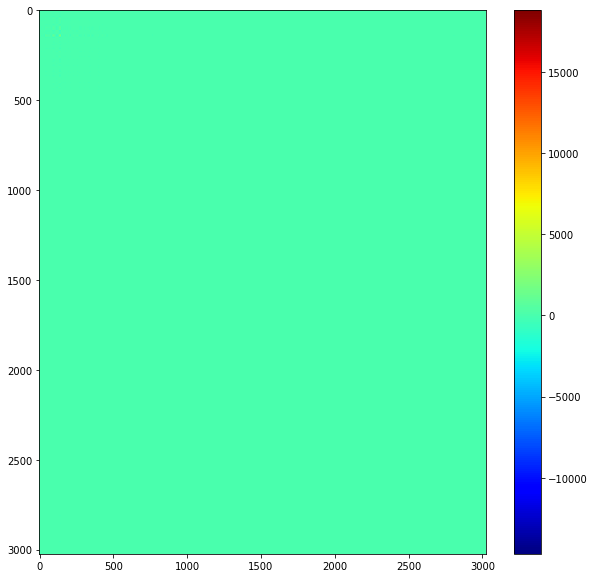

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(MVG[machine_types[0]]['cov'], aspect='auto', cmap='jet')
plt.colorbar()
plt.show()

## estimate

In [14]:
def calc_mahalanobis(mean, cov, samples):
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    dists = [mahalanobis(sample, mean, cov_inv) for sample in samples]
    # np.array
    dists = np.array(dists)
    return dists

In [15]:
from IPython.display import display

In [16]:
def get_score_perID(describe_df, max_fpr=0.1):
    # ユニークsectionを取得、昇順ソート
    sections = np.sort(describe_df['section_types'].unique())

    for section in sections:
        per_section_df = describe_df[describe_df['section_types'] == section]
        per_section_AUC = roc_auc_score(per_section_df['labels'], per_section_df['preds'])
        per_section_pAUC = roc_auc_score(per_section_df['labels'], per_section_df['preds'], max_fpr=max_fpr)
        # column = [AUC,pAUC], row = index
        score_df = pd.DataFrame(np.stack([per_section_AUC, per_section_pAUC]), index=['AUC', 'pAUC']).T
        # indexをsectionナンバーにrename
        # column = [AUC,pAUC], row = [section]
        score_df.index = [section]
        if section == 0:
            scores_df = score_df.copy()
        else:
            # 結合
            scores_df = scores_df.append(score_df)
    return scores_df

## Calc Score

In [17]:
for i, machine_type in enumerate(machine_types):
    logger.info('CALC SCORE')
    logger.info(machine_type)
    # get MVG
    tr_mean = MVG[machine_type]['mean']
    tr_cov = MVG[machine_type]['cov']
    # load samples
    ext_data = load_ext_data(machine_type)
    for phase in ['valid_source', 'valid_target']:
        # pred
        samples = ext_data[phase]['features']
        preds = calc_mahalanobis(tr_mean, tr_cov, samples)
        section_types = com.get_section_types(ext_data[phase]['wav_names'])
        # wavname + pred
        preds_pd = np.stack([np.array(ext_data[phase]['wav_names']), preds], axis=1)
        preds_pd = pd.DataFrame(preds_pd, columns=['wav_name', 'pred'])
        preds_pd.to_csv(OUT_PRED_DIR + f'/pred_{machine_type}_{phase}.csv')
        # dataframe作成
        describe_df = com.get_pred_discribe(labels=ext_data[phase]['labels'],
                                            preds=preds,
                                            section_types=section_types,
                                            wav_names=ext_data[phase]['wav_names'])
        # スコア算出(AUC, pAUC)
        scores_df = com.get_score_per_Section(describe_df, max_fpr=0.1)

        # 結合(source + target)
        scores_df = scores_df.rename(index=lambda num: 'id_0' + f'{num}')
        all_scores_df = scores_df.copy()
            
    # 平均
    mean_df = pd.DataFrame(all_scores_df.mean(axis=0)).T
    mean_df.index = ['mean']
    # 調和平均
    hmean = scipy.stats.hmean(all_scores_df, axis=0)
    hmean_df = pd.DataFrame(hmean, index=['AUC', 'pAUC']).T
    hmean_df.index = ['h_mean']
    # 結合
    all_scores_df = all_scores_df.append(mean_df)
    all_scores_df = all_scores_df.append(hmean_df)
    # 出力
    all_scores_df.to_csv(f'{OUT_SCORE_DIR}/{machine_type}_score.csv')
    # display
    display(all_scores_df)

2021-08-11 13:06:29,061 - 01_eval.py - INFO - CALC SCORE
2021-08-11 13:06:29,062 - 01_eval.py - INFO - fan


,AUC,pAUC
id_00,0.439300,0.490000
id_01,0.500000,0.519474
id_02,0.557400,0.511053
mean,0.498900,0.506842
h_mean,0.494202,0.506535


2021-08-11 13:06:36,773 - 01_eval.py - INFO - CALC SCORE
2021-08-11 13:06:36,774 - 01_eval.py - INFO - gearbox


,AUC,pAUC
id_00,0.609279,0.500995
id_01,0.562071,0.492907
id_02,0.637698,0.568713
mean,0.603016,0.520872
h_mean,0.601376,0.518747


2021-08-11 13:06:44,197 - 01_eval.py - INFO - CALC SCORE
2021-08-11 13:06:44,198 - 01_eval.py - INFO - pump


,AUC,pAUC
id_00,0.523700,0.491579
id_01,0.431000,0.489474
id_02,0.502600,0.501053
mean,0.485767,0.494035
h_mean,0.482367,0.493984


2021-08-11 13:06:50,720 - 01_eval.py - INFO - CALC SCORE
2021-08-11 13:06:50,721 - 01_eval.py - INFO - slider


,AUC,pAUC
id_00,0.598200,0.530526
id_01,0.425408,0.481310
id_02,0.576990,0.487242
mean,0.533533,0.499693
h_mean,0.521241,0.498757


2021-08-11 13:06:58,407 - 01_eval.py - INFO - CALC SCORE
2021-08-11 13:06:58,408 - 01_eval.py - INFO - ToyCar


,AUC,pAUC
id_00,0.471100,0.520526
id_01,0.475200,0.485789
id_02,0.412400,0.480526
mean,0.452900,0.495614
h_mean,0.450999,0.494993


2021-08-11 13:07:05,336 - 01_eval.py - INFO - CALC SCORE
2021-08-11 13:07:05,337 - 01_eval.py - INFO - ToyTrain


,AUC,pAUC
id_00,0.468200,0.498421
id_01,0.437400,0.496316
id_02,0.604100,0.516842
mean,0.503233,0.503860
h_mean,0.493630,0.503693


2021-08-11 13:07:11,538 - 01_eval.py - INFO - CALC SCORE
2021-08-11 13:07:11,539 - 01_eval.py - INFO - valve


,AUC,pAUC
id_00,0.527600,0.497895
id_01,0.560400,0.498421
id_02,0.497400,0.492632
mean,0.528467,0.496316
h_mean,0.527216,0.496302


In [18]:
for i, machine_type in enumerate(machine_types):
    logger.info('CALC SCORE')
    logger.info(machine_type)
    # get MVG
    tr_mean = MVG[machine_type]['mean']
    tr_cov = MVG[machine_type]['cov']
    # load samples
    ext_data = load_ext_test_data(machine_type)
    for phase in ['eval_test']:
        # pred
        samples = ext_data[phase]['features']
        preds = calc_mahalanobis(tr_mean, tr_cov, samples)
        section_types = com.get_id(ext_data[phase]['wav_names'])
        # wavname + pred
        preds_pd = np.stack([preds, section_types, np.array(ext_data[phase]['wav_names'])], axis=1)
        preds_pd = pd.DataFrame(preds_pd, columns=['preds', 'section_types', 'wav_names'])
        preds_pd.to_csv(OUT_PRED_DIR + f'/pred_{machine_type}_{phase}.csv')
        # dataframe作成
#         describe_df = com.get_pred_discribe(labels=ext_data[phase]['labels'],
#                                             preds=preds,
#                                             section_types=section_types,
#                                             wav_names=ext_data[phase]['wav_names'])
#         # スコア算出(AUC, pAUC)
#         scores_df = com.get_score_per_Section(describe_df, max_fpr=0.1)

#         # 結合(source + target)
#         scores_df = scores_df.rename(index=lambda num: 'id_0' + f'{num}')
#         all_scores_df = scores_df.copy()
            
#     # 平均
#     mean_df = pd.DataFrame(all_scores_df.mean(axis=0)).T
#     mean_df.index = ['mean']
#     # 調和平均
#     hmean = scipy.stats.hmean(all_scores_df, axis=0)
#     hmean_df = pd.DataFrame(hmean, index=['AUC', 'pAUC']).T
#     hmean_df.index = ['h_mean']
#     # 結合
#     all_scores_df = all_scores_df.append(mean_df)
#     all_scores_df = all_scores_df.append(hmean_df)
#     # 出力
#     all_scores_df.to_csv(f'{OUT_SCORE_DIR}/{machine_type}_score.csv')
#     # display
#     display(all_scores_df)

2021-08-11 13:07:18,635 - 01_eval.py - INFO - CALC SCORE
2021-08-11 13:07:18,636 - 01_eval.py - INFO - fan


FileNotFoundError: [Errno 2] No such file or directory: '/media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_frame257/dcase2021_task2/extraction_features/fan_features_test.pkl'

In [ ]:
preds = calc_mahalanobis(tr_mean, tr_cov, samples)
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')
    
    plt.figure(figsize=(20,3))
    plt.title(f'Source {machine_type}')
    plt.plot(valid_source_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_source']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,3))
    plt.title(f'Target {machine_type}')
    plt.plot(valid_target_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_target']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()

## calc GMM

In [ ]:
machine_types

In [ ]:
ext_data = load_ext_data(machine_types[6])
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(ext_data['train']['features'])

In [ ]:
gmm.bic(ext_data['train']['features'])

In [ ]:
pred = gmm.predict(ext_data['train']['features'])

In [ ]:
plt.hist(pred)

In [ ]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_

In [ ]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_


# calc mahalanobis (Anomaly Score)
valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]

In [ ]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = MVG[machine_type]['cov']
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')

In [ ]:
gmm_section_types = gmm.predict(feats)

In [ ]:
sns.distplot(section_types)

In [ ]:
sns.displot(gmm_section_types)